<a href="https://colab.research.google.com/github/mathmca/udemy_portfolio/blob/main/udemy_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Udemy Price Strategy

We are making three hypothesis to select our data of interest. They are:
1. There are Price Makers: Those who have a lot of comments, followers and reviews (The assumption is: Having more comments, reviews and followers they might offer a higher price; if they are in this position they know how to adjust their price)
2. There are Price Takers: Those who are new to the plataform, do not have (or have a lower amount) comments, feedbacks, followers. We are assuming that they do not have power to choose the fair price, mainly based on market conditions.
3. The new content creator will choose the avarege price, the most commun price or below of him to catch a piece of the market
**To choose a fair price, the content creator need to study the market and their competitors, losing time that could be used to improve their content **

Thus, we are going to focus on these targets: ***The avarage market***


## Getting the data

In [8]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
! cp kaggle.json ~/.kaggle/

In [11]:
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
! kaggle datasets download -d andrewmvd/udemy-courses

  0% 0.00/200k [00:00<?, ?B/s]
100% 200k/200k [00:00<00:00, 73.5MB/s]


In [45]:
from zipfile import ZipFile
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats


class data_saveload():
  def __init__(self, data_path: str, ArchName: str, filename: str):
    self.data_path = data_path
    self.filename = filename
    self.ArchName = ArchName
  def savedata(self):
    os.makedirs(self.data_path, exist_ok=True)
    if self.ArchName.endswith('.zip'):
      zip_path = os.path.join(os.getcwd(), self.ArchName)
      with ZipFile(zip_path, 'r') as zip:
        zip.printdir()
        zip.extractall(path=self.data_path)
        print('Finished!')
    else:
      os.path.join(data_path, self.filename)
  def loadata(self):
    arch = os.path.join(self.data_path, self.filename)
    return pd.read_csv(arch)
  def load_save(self):
    self.savedata()
    return self.loadata()

data_path = os.path.join(os.getcwd(), "database")

In [14]:
df_original = data_saveload(data_path=data_path, ArchName='udemy-courses.zip', filename='udemy_courses.csv')
df = df_original.load_save()

File Name                                             Modified             Size
udemy_courses.csv                              2020-05-17 00:01:44       693946
Finished!


## Data Overview

There is a problem with "is_paid". Even if "is_paid==False(or True)", they have a price (or not). Therefore it is worthless and problematic. Then, I droped it

In [15]:
# Dropping irrelevant columns

df.drop(labels=['course_id', 'course_title', 'url', 'published_timestamp', 'is_paid'], inplace=True, axis=1)

In [16]:
df

,price,num_subscribers,num_reviews,num_lectures,level,content_duration,subject
0,200,2147,23,51,All Levels,1.5,Business Finance
1,75,2792,923,274,All Levels,39.0,Business Finance
2,45,2174,74,51,Intermediate Level,2.5,Business Finance
3,95,2451,11,36,All Levels,3.0,Business Finance
4,200,1276,45,26,Intermediate Level,2.0,Business Finance
...,...,...,...,...,...,...,...
3673,100,1040,14,21,All Levels,2.0,Web Development
3674,25,306,3,42,Beginner Level,3.5,Web Development
3675,40,513,169,48,All Levels,3.5,Web Development
3676,50,300,31,38,All Levels,3.0,Web Development


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             3678 non-null   int64  
 1   num_subscribers   3678 non-null   int64  
 2   num_reviews       3678 non-null   int64  
 3   num_lectures      3678 non-null   int64  
 4   level             3678 non-null   object 
 5   content_duration  3678 non-null   float64
 6   subject           3678 non-null   object 
dtypes: float64(1), int64(4), object(2)
memory usage: 201.3+ KB


We observe a huge deviation present in all features

In [18]:
df.describe()

,price,num_subscribers,num_reviews,num_lectures,content_duration
count,3678.000000,3678.000000,3678.000000,3678.000000,3678.000000
mean,66.049483,3197.150625,156.259108,40.108755,4.094517
std,61.005755,9504.117010,935.452044,50.383346,6.053840
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,111.000000,4.000000,15.000000,1.000000
50%,45.000000,911.500000,18.000000,25.000000,2.000000
75%,95.000000,2546.000000,67.000000,45.750000,4.500000
max,200.000000,268923.000000,27445.000000,779.000000,78.500000


In [19]:
# Looking for duplicated values
print(df.duplicated().value_counts())
df.drop_duplicates(inplace=True)

False    3669
True        9
dtype: int64


In [20]:
print(df.level.unique(), df.subject.unique(), '\n-----------') # For dummy selection
print(df.isnull().sum()) # Looking for missing values (None)

['All Levels' 'Intermediate Level' 'Beginner Level' 'Expert Level'] ['Business Finance' 'Graphic Design' 'Musical Instruments'
 'Web Development'] 
-----------
price               0
num_subscribers     0
num_reviews         0
num_lectures        0
level               0
content_duration    0
subject             0
dtype: int64


As we can see we have a really variable price distribution. We are going to delete all of the prices above 60 (Price makers) and equal to zero (is not paid), keeping the eyes on the avarage (Price takers).

---
We have long tail distributions in all of others distributions. They are all assymetric (right-skewed).

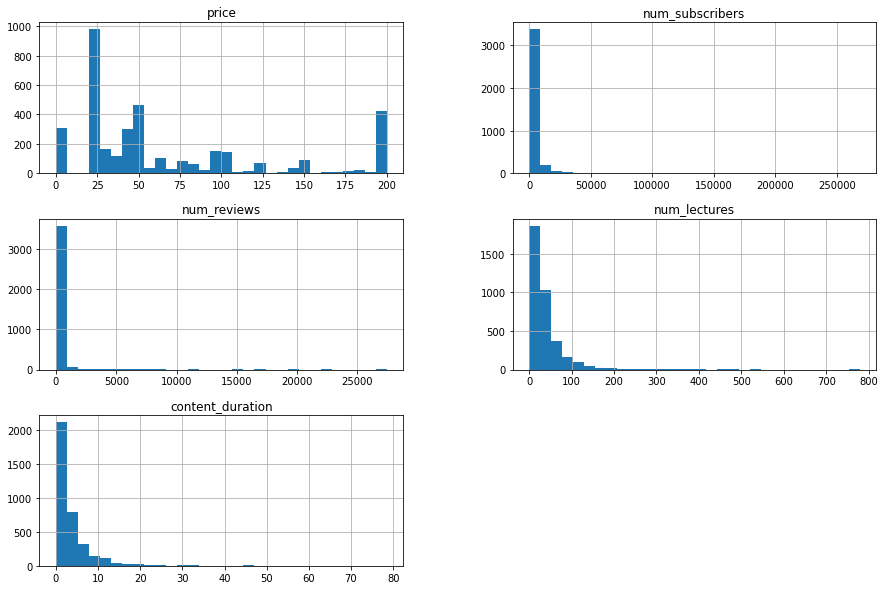

In [21]:
df.hist(bins=30, figsize=(15, 10))
plt.show()

It seems that "num_lectures" is the highest linear influence on the price. It is reasonable if they approach a large number of subjects.

In [22]:
df.corr()

,price,num_subscribers,num_reviews,num_lectures,content_duration
price,1.000000,0.050327,0.113522,0.329800,0.293093
num_subscribers,0.050327,1.000000,0.651062,0.158209,0.162027
num_reviews,0.113522,0.651062,1.000000,0.242975,0.228815
num_lectures,0.329800,0.158209,0.242975,1.000000,0.801601
content_duration,0.293093,0.162027,0.228815,0.801601,1.000000


The hypotesis (1 and 2) are correct altough the presence of some outliers. We can see this below with the Scatter Matrix plot.

In [23]:
px.scatter_matrix(df, dimensions=['price', 'num_subscribers', 'num_reviews',
       'num_lectures', 'content_duration'], color='price', title='Scatter Matrix', height=900)

Testing features combinations

In [24]:
df['durationbylect'] = df['content_duration']//df['num_lectures']
df['reviewpersubs'] = df['num_reviews']//df['num_subscribers']
df.corrwith(df['price']) 
#There is not any relevant combination, dropping these columns
df.drop(['durationbylect', 'reviewpersubs'], axis=1, inplace=True)

Removing Outliers

In [25]:
df = df[(df['price'] < 60) & (df['price'] < 60) & (df['num_subscribers'] < 4000)]
df

,price,num_subscribers,num_reviews,num_lectures,level,content_duration,subject
2,45,2174,74,51,Intermediate Level,2.5,Business Finance
12,30,3607,21,19,All Levels,1.5,Business Finance
23,50,1916,38,23,Beginner Level,1.0,Business Finance
24,45,2507,333,40,All Levels,2.0,Business Finance
58,20,936,6,11,Intermediate Level,1.5,Business Finance
...,...,...,...,...,...,...,...
3671,20,436,36,22,Intermediate Level,1.5,Web Development
3674,25,306,3,42,Beginner Level,3.5,Web Development
3675,40,513,169,48,All Levels,3.5,Web Development
3676,50,300,31,38,All Levels,3.0,Web Development


Our deviation was reduced, mainly in the price, but we have reduced our degrees of freedom. There is fewer observations now.

In [26]:
df.describe()

,price,num_subscribers,num_reviews,num_lectures,content_duration
count,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000
mean,30.419546,801.853899,25.853406,29.924482,2.998659
std,14.526152,971.190800,47.940979,32.289473,4.206825
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,46.250000,2.000000,12.000000,1.000000
50%,25.000000,353.500000,9.000000,21.000000,2.000000
75%,45.000000,1289.500000,27.000000,35.000000,3.500000
max,55.000000,3960.000000,529.000000,458.000000,78.500000


## Transformation Pipeline

* I am going to use a teste size of 0.10. We do not have too much data to train. If I am in a situation that the project is a must, I would priorize our train size set.

* After this brief view, let's split our train and test dataset before do any data transformation. I will use the random sample and I will let the seed, because I will restart this notebook several times.

In [27]:
# Splitting the data

x = df.drop('price', axis=1)
y = df['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)

In [28]:
# Splitting by categories

x_train_num = x_train.select_dtypes(include=[np.number])
x_train_cat = x_train.select_dtypes(exclude=[np.number, 'bool'])
x_train_binary = x_train.select_dtypes(include='bool')

In [29]:
# Manually checking if everything fits perfectly
encoder = OneHotEncoder()
x_train_cat_tr = encoder.fit_transform(x_train_cat[['level', 'subject']])
print(encoder.get_feature_names_out())

['level_All Levels' 'level_Beginner Level' 'level_Expert Level'
 'level_Intermediate Level' 'subject_Business Finance'
 'subject_Graphic Design' 'subject_Musical Instruments'
 'subject_Web Development']


I need to create a custom class for the "LabelBinarizer" beucase he does not handle more than 2 arguments

In [30]:
# Would be used to fit "is_paid" in the pipeline.
# I am going to keep it, might be useful afterwards.
class binarytransformer(BaseEstimator, TransformerMixin):
  def __init__(self, sparse_output=False):
    self.sparse_output = sparse_output
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    binarizer = LabelBinarizer(sparse_output=self.sparse_output)
    return binarizer.fit_transform(X)

### Pipeline

Manually would be

In [31]:
# Creating the dummy for "is_paid"
#x_train['is_paid'] = x_train['is_paid'].apply(lambda x: 1 if x == True else 0)

# Creating dummy variables for "level"
dummy_level = pd.get_dummies(x_train.level)
concat_df = pd.concat([x_train, dummy_level], axis=1)

#Creating dummy variables for "subject"
dummy_subject = pd.get_dummies(x_train.subject)
subject_df = pd.concat([concat_df, dummy_subject], axis=1)

#The final DataFrame
datam = subject_df.drop(['level', 'subject'], axis=1)
datam

,num_subscribers,num_reviews,num_lectures,content_duration,All Levels,Beginner Level,Expert Level,Intermediate Level,Business Finance,Graphic Design,Musical Instruments,Web Development
1831,122,9,11,0.633333,0,1,0,0,0,0,1,0
474,911,2,18,1.500000,1,0,0,0,1,0,0,0
3664,944,1,10,1.000000,1,0,0,0,0,0,0,1
2423,1981,28,38,2.000000,0,1,0,0,0,0,1,0
509,83,8,21,1.000000,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1851,886,43,74,1.500000,0,0,0,1,0,0,1,0
2121,5,2,19,2.000000,0,0,0,1,0,0,1,0
1478,13,3,22,2.000000,0,1,0,0,0,1,0,0
2315,245,8,34,1.500000,0,0,0,1,0,0,1,0


It is totally reasonable a higher negative correlation between the courses - and positive between contend_duration and num_lectures

In [32]:
px.imshow(datam.corr(), text_auto=True, width=1400, height=1000, template='ggplot2')

* The distribution has a high variability, thus I have chosen the median and not the mean as "imputer"

* There are a lot of outliers in this data set, thus I used the StandardScaler()

In [33]:
# Defining the numerical Pipeline

pipeline_num = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
  ])

# Putting all together in the Transformer

final_pipeline = ColumnTransformer([
    ('numerical', pipeline_num, list(x_train_num)),
    ('categorical', OneHotEncoder(sparse=False), list(x_train_cat)),
    #('binarizer', binarytransformer(), ['is_paid'])
  ])

# Fitting and Transforming the specified columns

x_train_tr = final_pipeline.fit_transform(x_train)

In [34]:
dataf = pd.DataFrame(x_train_tr, columns=list(x_train_num.columns) + list(encoder.get_feature_names_out()), index = x_train.index)
dataf.columns = dataf.columns.str.replace('/|(level_)|(subject_)|/', '', regex=True)
dataf

,num_subscribers,num_reviews,num_lectures,content_duration,All Levels,Beginner Level,Expert Level,Intermediate Level,Business Finance,Graphic Design,Musical Instruments,Web Development
1831,-0.698830,-0.352716,-0.579047,-0.549285,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
474,0.114960,-0.496184,-0.367648,-0.349835,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3664,0.148997,-0.516679,-0.609246,-0.464902,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2423,1.218578,0.036696,0.236347,-0.234768,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
509,-0.739055,-0.373212,-0.277049,-0.464902,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1851,0.089174,0.344127,1.323537,-0.349835,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2121,-0.819506,-0.496184,-0.337449,-0.234768,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1478,-0.811254,-0.475689,-0.246849,-0.234768,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2315,-0.571965,-0.373212,0.115548,-0.349835,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Model selection and training

* We have an overfitting with the Decision Tree
* We expected the Random Forest as the best predictor

In [61]:
def display_errors(labels, predictions):
  print('RMSE:', mean_squared_error(labels, predictions, squared=False))
  print('MAE:', mean_absolute_error(labels, predictions))

def dispaly_accuracy(labels, predictions):
  errors = abs(labels - predictions)
  mape = 100 * np.mean(errors / labels)
  accuracy = 100 - mape
  print(f"Accuracy: {accuracy:5.2f} %")

lnreg_pipeline = Pipeline([
    ('transformation', final_pipeline),
    ('polyfeatures', PolynomialFeatures()),
    ('lnreg', LinearRegression()),
  ])

tree_pipeline = Pipeline([
    ('transformation', final_pipeline),
    ('tree', DecisionTreeRegressor()),
  ])

forest_pipeline = Pipeline([
    ('transformation', final_pipeline),
    ('forest', RandomForestRegressor()),
  ])

svr_pipeline = Pipeline([
    ('transformation', final_pipeline),
    ('svr', SVR(kernel='rbf', C=100)),
  ])

knn_pipeline = Pipeline([
    ('transformation', final_pipeline),
    ('knn', KNeighborsRegressor()),
  ])

pipes = [lnreg_pipeline, tree_pipeline, forest_pipeline, svr_pipeline, knn_pipeline]

names = ['Polynomial Regression', 'Decision Tree', 'Random Forest', 'SVR', 'KNN']


for i, pipe in zip(names, pipes):
  pipe.fit(x_train, y_train)
  predictions = pipe.predict(x_train)
  print('Name:', i)
  display_errors(y_train, predictions)

Name: Polynomial Regression
RMSE: 13.157438874569577
MAE: 10.951621057025843
Name: Decision Tree
RMSE: 0.4968358466083553
MAE: 0.016456390565002744
Name: Random Forest
RMSE: 5.157952509515824
MAE: 4.114468693676044
Name: SVR
RMSE: 12.502542274127741
MAE: 8.778355484466259
Name: KNN
RMSE: 11.696800412049434
MAE: 9.206801974766869


### Cross-validation 

Random Forest was the best model

In [62]:
# Using k-fold

for i, model in zip(names, pipes):
  print('Model:', i)
  scores = cross_val_score(model, x_train, y_train,
                               scoring='neg_mean_squared_error', cv=5)
  rmse_scores = np.sqrt(-scores)
  print(np.mean(rmse_scores))
  print('-----------------------')

Model: Polynomial Regression
13.75216998908571
-----------------------
Model: Decision Tree
18.454186073869405
-----------------------
Model: Random Forest
13.640272193981454
-----------------------
Model: SVR
14.476825405978357
-----------------------
Model: KNN
14.230570720754509
-----------------------


### Model Boosting

Since I just have a few models to try and I just want to test different hiperparamters, I used randomized search.




In [37]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


model = RandomForestRegressor()
rand_search = RandomizedSearchCV(model, n_iter=100, cv=4,
                                 param_distributions=random_grid,
                                 scoring='neg_mean_squared_error',
                                 verbose=2, n_jobs=-1, random_state=42)

rand_search.fit(x_train_tr, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [38]:
f_importance = rand_search.best_estimator_.feature_importances_
attributes = dataf.columns
print(sorted(zip(f_importance, attributes), reverse=True))
print('\nBest Score Error:', np.sqrt(-rand_search.best_score_))

[(0.2625524557391591, 'num_subscribers'), (0.21382985296724658, 'num_lectures'), (0.18149882515436824, 'content_duration'), (0.16902447946030347, 'num_reviews'), (0.03317792347877378, 'Graphic Design'), (0.031221481065131337, 'Musical Instruments'), (0.031057507522714436, 'Beginner Level'), (0.02330548128438969, 'Business Finance'), (0.021181379304860925, 'All Levels'), (0.01931236880382591, 'Web Development'), (0.01264502133414857, 'Intermediate Level'), (0.001193223885077925, 'Expert Level')]

Best Score Error: 13.27605606378501


## Testing in the test_set

In [41]:
final_model = rand_search.best_estimator_
x_test_tr = final_pipeline.transform(x_test)
final_predictions = final_model.predict(x_test_tr)
display_errors(y_test, final_predictions)

RMSE: 13.230795124698638
MAE: 10.891758828742079


## Conclusions